In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import datetime

import pickle

import random

import torch.nn as nn

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep 12 12:54:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data


from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df1 = pd.read_csv('/content/drive/MyDrive/code_H2_/fridge_freezer/refit_normal_consumption_fridge_freezer/df_H15_fridge_freezer_normal.csv')
df2 = pd.read_csv('/content/drive/MyDrive/code_H2_/fridge_freezer/refit_normal_consumption_fridge_freezer/df_H2_fridge_freezer_normal.csv')
df3 = pd.read_csv('/content/drive/MyDrive/code_H2_/fridge_freezer/refit_normal_consumption_fridge_freezer/df_h9_fridge_freezer_normal.csv')
df4 = pd.read_csv('/content/drive/MyDrive/code_H2_/fridge_freezer/house3_anotated.csv')


In [6]:
df4.head(3)

,unix,time,aggregate,washing machine,tumble dryer,fridge freezer,freezer,dishwasher,toaster,microwave,television,kettle,agg_4p,type_defaut_Fridge_Freezer,anomaly,type_defaut_dishwasher,type_defaut_Freezer,type_defaut_TumbleDryer
0,1395360000,2014-03-21 00:00:00,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,1395360008,2014-03-21 00:00:08,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,1395360016,2014-03-21 00:00:16,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [7]:

def window_array_overlap(array, window_size, overlap):
  """Transforme un array en entrée du VAE avec des fenêtres glissantes et avec/sans chevauchement.

  Args:
      array: Le array d'entrée en 1D.
      window_size: La taille de chaque fenêtre.
      overlap: Le nombre d'éléments de chevauchement entre les fenêtres.

  Returns:
      Un array 3D avec les fenêtres glissantes.
  """

  # Calcul du nombre de fenêtres
  num_windows = (len(array) - window_size) // (window_size - overlap) + 1
  print(f'num_windows {num_windows}')

  # Création de l'array 3D
  windows = np.zeros((num_windows, window_size))

  # Génération des fenêtres glissantes avec chevauchement
  for i in range(num_windows):
    start = i * (window_size - overlap)
    end = start + window_size
    windows[i] = array[start:end]

  return windows



In [8]:
df4.head(2)

,unix,time,aggregate,washing machine,tumble dryer,fridge freezer,freezer,dishwasher,toaster,microwave,television,kettle,agg_4p,type_defaut_Fridge_Freezer,anomaly,type_defaut_dishwasher,type_defaut_Freezer,type_defaut_TumbleDryer
0,1395360000,2014-03-21 00:00:00,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,1395360008,2014-03-21 00:00:08,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [9]:
df1.shape

(4656600, 6)

In [10]:
4656600/ 1000

4656.6

In [10]:
# division en sequence de 1000, don't forget sampling_factor
seq_h15 = window_array_overlap(np.array(df1['fridge freezer']), 800, 500)
seq_h2 = window_array_overlap(np.array(df2['fridge freezer']), 800, 500)
seq_h9 = window_array_overlap(np.array(df3['fridge freezer']), 800, 500)
seq_h3_anotated = window_array_overlap(np.array(df4['fridge freezer']), 800, 0)


num_windows 15520
num_windows 15540
num_windows 15145
num_windows 5845


In [11]:
x_train = np.concatenate((seq_h15, seq_h2, seq_h9), axis=0)
print(x_train.shape)

(46205, 800)


In [12]:
scaler = StandardScaler()


In [13]:
train_data_normalized = scaler.fit_transform(x_train)


In [14]:
#test_data = scaler.fit_transform(seq_h20)
test_data_anotated = scaler.fit_transform(seq_h3_anotated)

In [15]:
train_data_normalized.shape, test_data_anotated.shape

((46205, 800), (5845, 800))

In [16]:
# getting the labels for the finale test step

In [17]:
df4.head(2)

,unix,time,aggregate,washing machine,tumble dryer,fridge freezer,freezer,dishwasher,toaster,microwave,television,kettle,agg_4p,type_defaut_Fridge_Freezer,anomaly,type_defaut_dishwasher,type_defaut_Freezer,type_defaut_TumbleDryer
0,1395360000,2014-03-21 00:00:00,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,1395360008,2014-03-21 00:00:08,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [18]:
df4 = df4[['unix', 'time', 'aggregate', 'fridge freezer', 'type_defaut_Fridge_Freezer']]
df4.head(2)

,unix,time,aggregate,fridge freezer,type_defaut_Fridge_Freezer
0,1395360000,2014-03-21 00:00:00,302.0,0.0,0
1,1395360008,2014-03-21 00:00:08,302.0,0.0,0


In [19]:

# ici je met la fonction qui utilise les donné anoté et revoi les label
df4.head(3)
#df4 = df4[['unix', 'freezer', 'type_defaut_freezer']]
list_anomaly = []
for i in df4['type_defaut_Fridge_Freezer'] :
    if (i ==1) or (i==2) :
        list_anomaly.append(1)
    else:
        list_anomaly.append(0)

df4['anomaly'] = list_anomaly
print(f'liste des des anomalies annoté est de taille : {len(list_anomaly)} et les valeur unique sont {np.unique(list_anomaly)}')




# Définition de la taille de la séquence
sequence_length = 800
seuil = 10

# Fonction pour diviser le DataFrame en séquences et les labelliser
def create_sequences_and_labels(df3, sequence_length, seuil):
    sequences = []
    labels = []

    # Nombre total de séquences possibles
    num_sequences = len(df3) // sequence_length

    for i in range(num_sequences):
        # Sélectionner la séquence
        sequence = df3.iloc[i * sequence_length : (i + 1) * sequence_length]

        # Vérifier le nombre d'anomalies dans la séquence
        anomaly_count = sequence['anomaly'].sum()

        # Déterminer le label de la séquence
        label = 1 if anomaly_count >= seuil else 0

        # Ajouter la séquence et le label à la liste
        sequences.append(sequence['fridge freezer'].values)
        labels.append(label)

    return np.array(sequences), np.array(labels)


sequence_test, labesl_test = create_sequences_and_labels(df4, sequence_length, seuil)

print(len(labesl_test))

liste des des anomalies annoté est de taille : 4676401 et les valeur unique sont [0 1]
5845


In [21]:
test_data_anotated.shape

(5845, 800)

In [20]:
sequence_test_normalized = scaler.fit_transform(sequence_test)

In [ ]:
sequence_test_normalized == test_data_anotated

ValueError: operands could not be broadcast together with shapes (4676,1000) (5845,800) 

In [21]:
## le model
import torch
import torch.nn as nn
from torch.nn import functional as F

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TCNBlock, self).__init__()
        #padding = (kernel_size - 1) * dilation  # Causal padding, j'ai modifier ici
        padding = (kernel_size // 2) * dilation#(kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.activation = nn.ReLU()
        self.norm = nn.BatchNorm1d(out_channels)
        self.drop = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        x = self.norm(x)
        x = self.drop(x)
        return x

class TCNEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rates, sampling_factor):
        super(TCNEncoder, self).__init__()
        self.dilation_rates = dilation_rates
        self.sampling_factor = sampling_factor
        self.tcn_layers = nn.ModuleList([
            TCNBlock(in_channels if i == 0 else out_channels, out_channels, kernel_size, dilation)
            for i, dilation in enumerate(dilation_rates)
        ])
        self.conv1d = nn.Conv1d(out_channels, 8, kernel_size=1, padding=0)  # 1x1 convolution for dimensionality reduction, en metant padding 0, ca va reduire la taille de la séquence

    def forward(self, x):
        #print(f'before encoder {x.shape}')
        for layer in self.tcn_layers:
            x = layer(x)
            #print(f'in the layers {x.shape}')
        #print(f'after alla layers {x.shape}')
        x = self.conv1d(x)  # Dimensionality reduction
        #print(f'after the conv1d {x.shape}')
        x = F.avg_pool1d(x, kernel_size=self.sampling_factor)  # downsampling,  revoir
        #print(f'after the downsampling {x.shape}')
        return x

class TCNDecoder(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rates, sampling_factor):
        super(TCNDecoder, self).__init__()
        self.dilation_rates = dilation_rates
        self.sampling_factor = sampling_factor
        self.tcn_layers = nn.ModuleList([
            #TCNBlock(8 if i == 0 else out_channels, out_channels, kernel_size, dilation)
            TCNBlock(8 if i == 0 else  in_channels, in_channels, kernel_size, dilation)
            for i, dilation in enumerate(dilation_rates)
        ])
        self.upsample = nn.Upsample(scale_factor=self.sampling_factor, mode='nearest')  # upsampling
        #self.conv1d = nn.Conv1d(out_channels, in_channels, kernel_size=1, padding=0)  # 1x1 convolution for reconstruction
        self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        #print(f'before decoder {x.shape}')
        x = self.upsample(x)
        #print(f'after upsamling {x.shape}')  # Upsampling to original length
        for layer in self.tcn_layers:
            x = layer(x)
            #print(f'in the layers {x.shape}')
        #print(f'after alla layers {x.shape}')

        #print(x.shape)
        #print(out_channels)
        x = self.conv1d(x)
        #print(f'after the last conv1d of the decoder {x.shape}')  # Reconstruct the original dimensionality
        #print(x.shape)
        return x

class TCNAE(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rates, sampling_factor):
        super(TCNAE, self).__init__()
        self.encoder = TCNEncoder(in_channels, out_channels, kernel_size, dilation_rates, sampling_factor)
        self.decoder = TCNDecoder(out_channels, in_channels, kernel_size, dilation_rates, sampling_factor)

    def forward(self, x):

        encoded = self.encoder(x)
        #print(encoded.shape)

        decoded = self.decoder(encoded)
        return decoded




In [22]:
# Example usage
# Assuming your time series data is stored in a PyTorch tensor of shape (batch_size, features, sequence_length)
batch_size = 64
sequence_length = 800
features = 1
dilation_rates = [1, 2, 4, 8, 16]  # Example dilation rates
sampling_factor = 10#40  # Downsampling factor
kernel_size = 21
out_channels = 20

In [23]:
# Convert the training data to PyTorch tensors
train_data_normalized = torch.from_numpy(train_data_normalized)


#input_size = x_train.shape[1] # taille de l'entrée (séquence de longueur 1000), maybe i should change this one
#latent_dim = 128  # 125 ? non

# Ccreate the autoencoder model and optimizer
model = TCNAE(features, out_channels, kernel_size, dilation_rates, sampling_factor)



In [24]:
# Define the loss function
# nn.MSELoss(reduction='none')

criterion = nn.MSELoss()
criterion_mae = nn.L1Loss()
#criterion = nn.MSELoss(reduction='none')

#

In [25]:
learning_rate = 0.001# %0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
800 / 10

80.0

In [27]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TCNAE(
  (encoder): TCNEncoder(
    (tcn_layers): ModuleList(
      (0): TCNBlock(
        (conv): Conv1d(1, 20, kernel_size=(21,), stride=(1,), padding=(10,))
        (activation): ReLU()
        (norm): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): TCNBlock(
        (conv): Conv1d(20, 20, kernel_size=(21,), stride=(1,), padding=(20,), dilation=(2,))
        (activation): ReLU()
        (norm): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (2): TCNBlock(
        (conv): Conv1d(20, 20, kernel_size=(21,), stride=(1,), padding=(40,), dilation=(4,))
        (activation): ReLU()
        (norm): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (3): TCNBlock(
        (conv): Conv1d(20, 20, kernel_size=(21,), stri

In [28]:
device

device(type='cuda')

In [29]:
summary(model, (1, 800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 20, 800]             440
              ReLU-2              [-1, 20, 800]               0
       BatchNorm1d-3              [-1, 20, 800]              40
           Dropout-4              [-1, 20, 800]               0
          TCNBlock-5              [-1, 20, 800]               0
            Conv1d-6              [-1, 20, 800]           8,420
              ReLU-7              [-1, 20, 800]               0
       BatchNorm1d-8              [-1, 20, 800]              40
           Dropout-9              [-1, 20, 800]               0
         TCNBlock-10              [-1, 20, 800]               0
           Conv1d-11              [-1, 20, 800]           8,420
             ReLU-12              [-1, 20, 800]               0
      BatchNorm1d-13              [-1, 20, 800]              40
          Dropout-14              [-1, 

In [30]:
# Create a DataLoader, dans cette partie pas de shuffle
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_data_normalized, batch_size=batch_size
)

In [31]:
len(train_loader)

722

In [32]:
criterion2 = nn.MSELoss(reduction='none')

In [33]:
# Training loop
num_epochs = 332
list_loss = []
list_mae = []
for epoch in range(num_epochs):
    total_loss = 0.0
    total_mae = 0.0

    for batch_idx, data in enumerate(train_loader):
        # Get a batch of training data and move it to the device

        data = data.to(device).float()  #
        #print(data.shape)
        #data = data.float()

        data = torch.unsqueeze(data, 1)  # [32, 900] > [32, 1, 900] / 32, 900, 1
        #data = data.permute(0, 2, 1)
        #print(data.shape)

        x_recon= model(data)
        #print(f'x_recon shape {x_recon.shape}')

        # Compute the loss and perform backpropagation

        #print(x_recon.shape)
        #print(x_recon.shape)

        loss = criterion(x_recon, data)
        mae = criterion_mae(x_recon, data)



        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the running loss
        total_loss += loss.item() * data.size(0)
        total_mae += mae.item() * data.size(0)

        #if epoch == 331 :
         # recon_loss_each_seq = criterion2(x_recon, data)


    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    epoch_mae = total_mae / len(train_loader.dataset)
    print(
        "Epoch {}/{}: reconstruction_error_mse={:.6f} et mae={:.6}".format(epoch + 1, num_epochs, epoch_loss, epoch_mae)
    )
    list_loss.append(epoch_loss)
    list_mae.append(epoch_mae)
print(f' dernier epock mae {epoch_mae}')


Epoch 1/332: reconstruction_error_mse=0.254537 et mae=0.25519
Epoch 2/332: reconstruction_error_mse=0.181566 et mae=0.224706
Epoch 3/332: reconstruction_error_mse=0.153037 et mae=0.211494
Epoch 4/332: reconstruction_error_mse=0.139430 et mae=0.204898
Epoch 5/332: reconstruction_error_mse=0.129463 et mae=0.201203
Epoch 6/332: reconstruction_error_mse=0.122796 et mae=0.197568
Epoch 7/332: reconstruction_error_mse=0.119364 et mae=0.195905
Epoch 8/332: reconstruction_error_mse=0.116682 et mae=0.194803
Epoch 9/332: reconstruction_error_mse=0.119566 et mae=0.194179
Epoch 10/332: reconstruction_error_mse=0.113298 et mae=0.193028
Epoch 11/332: reconstruction_error_mse=0.110584 et mae=0.192301
Epoch 12/332: reconstruction_error_mse=0.110014 et mae=0.192472
Epoch 13/332: reconstruction_error_mse=0.109718 et mae=0.191642
Epoch 14/332: reconstruction_error_mse=0.107498 et mae=0.191678
Epoch 15/332: reconstruction_error_mse=0.107492 et mae=0.191088
Epoch 16/332: reconstruction_error_mse=0.104938 et

In [50]:
# enregistrer les poids du modèle

torch.save(model.state_dict(), '/content/drive/MyDrive/code_H2_/fridge_freezer/fridge_freezer_seq800_chev500/tcn_autoencoder_fridge_freezer_800_chev500weights_332epc.pth')

'''
pour récupere les parametres du modèle

model = TCNAE(in_channels, out_channels, kernel_size, dilation_rates, sampling_factor)
# charger les poids
model.load_state_dict(torch.load('tcn_autoencoder_weights.pth'))
# Assurez-vous de définir le modèle sur le bon dispositif (CPU ou GPU)
model.to(device)


'''


"\npour récupere les parametres du modèle\n\nmodel = TCNAE(in_channels, out_channels, kernel_size, dilation_rates, sampling_factor)\n# charger les poids\nmodel.load_state_dict(torch.load('tcn_autoencoder_weights.pth'))\n# Assurez-vous de définir le modèle sur le bon dispositif (CPU ou GPU)\nmodel.to(device)\n\n\n"

In [ ]:
31166.158642053604/2780

11.210848432393382

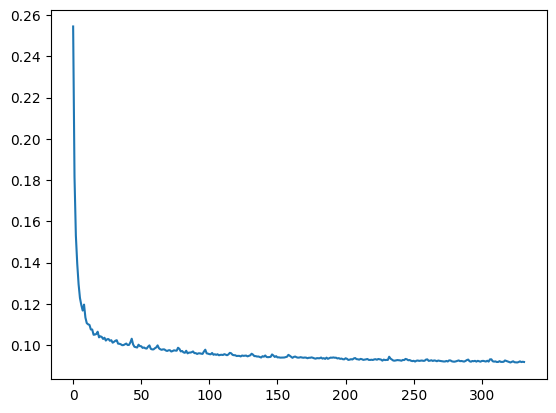

In [35]:
# 2 minuuute to get the first reconstruction error
plt.plot(list_loss)

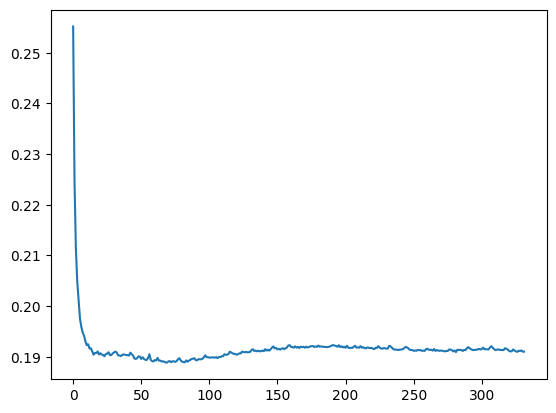

In [36]:
plt.plot(list_mae)

### on test sur anotated directement

In [ ]:
# on a non donner de test les deux en sequence sans chevauchement et normaliser, tesors and then evaluate, test_data,  test_data_anotated


In [37]:
test = test_data_anotated
test = torch.from_numpy(test)
test = test.unsqueeze(1)
test = test.to(device).float()
test = test.float()

In [41]:
#criterion2 = nn.MSELoss(reduction='none')

In [42]:
# Enregistrer uniquement les poids du modèle (state_dict)
#torch.save(model.state_dict(), '/content/drive/MyDrive/code_H2_/model_tcn_200.pth')

In [38]:
# Mettre le modèle en mode évaluation
model.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon = model(test)

    # Calculer la perte de reconstruction
    recon_loss = criterion(x_recon, test)

    recon_loss_mae = criterion_mae(x_recon, test)

    recon_loss_each_seq = criterion2(x_recon, test)

    rmse = torch.sqrt(recon_loss)

    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    #print(recon_loss)
    print(' mse : {}'.format(recon_loss))
    print(' rmse : {}'.format(rmse))
    print('mae : {}'.format(recon_loss_mae))
    print(recon_loss_each_seq)
%

 mse : 0.06513967365026474
 rmse : 0.2552247643470764
mae : 0.20706042647361755
tensor([[[1.0135e-01, 9.9819e-02, 7.7550e-02,  ..., 8.6116e-02,
          9.6128e-02, 9.4660e-02]],

        [[8.0774e-02, 7.9229e-02, 6.0522e-02,  ..., 8.4783e-02,
          8.6197e-02, 8.0284e-02]],

        [[7.9636e-02, 7.8721e-02, 6.0100e-02,  ..., 1.0635e-02,
          8.8451e-03, 1.1197e-02]],

        ...,

        [[8.6619e-02, 8.5722e-02, 6.6541e-02,  ..., 4.2838e-04,
          1.4391e-03, 1.4169e-05]],

        [[5.4572e-02, 5.4917e-02, 6.1031e-02,  ..., 1.0899e-03,
          1.3393e-03, 5.9334e-05]],

        [[1.7383e-02, 1.7138e-02, 2.7348e-02,  ..., 7.7696e-02,
          7.9047e-02, 7.4122e-02]]], device='cuda:0')


UsageError: Line magic function `%` not found.


In [43]:
# Mettre le modèle en mode évaluation
model.eval()

# Désactiver la rétropropagation pour économiser de la mémoire
with torch.no_grad():
    # Passer les données de test à travers le modèle
    x_recon = model(test)

    # Calculer la perte de reconstruction
    recon_loss = criterion(x_recon, test)

    recon_loss_mae = criterion_mae(x_recon, test)

    recon_loss_each_seq = criterion2(x_recon, test)

    rmse = torch.sqrt(recon_loss)

    #print("Reconstruction Loss on Test Data: {:.4f}".format(recon_loss))
    #print(recon_loss)
    print(' mse : {}'.format(recon_loss))
    print(' rmse : {}'.format(rmse))
    print('mae : {}'.format(recon_loss_mae))
    print(recon_loss_each_seq)
%

 mse : 0.07232656329870224
 rmse : 0.2689359784126282
mae : 0.21227476000785828
tensor([[[1.3708e-01, 1.3960e-01, 1.1970e-01,  ..., 1.6739e-01,
          1.7641e-01, 1.7926e-01]],

        [[1.2402e-01, 1.2420e-01, 9.9556e-02,  ..., 1.3328e-01,
          1.3337e-01, 1.3542e-01]],

        [[1.2090e-01, 1.2073e-01, 9.6157e-02,  ..., 1.0702e-03,
          7.5014e-04, 1.7779e-03]],

        ...,

        [[1.1594e-01, 1.0989e-01, 8.2415e-02,  ..., 2.8856e-03,
          1.7559e-03, 5.1176e-03]],

        [[7.9277e-05, 5.7584e-05, 2.0364e-04,  ..., 3.7531e-05,
          3.6935e-04, 2.3385e-05]],

        [[9.6287e-06, 5.4355e-05, 2.3839e-03,  ..., 1.3134e-01,
          1.5622e-01, 2.1941e-01]]], device='cuda:0')


UsageError: Line magic function `%` not found.


In [39]:
# enregistrer la séquence 'x_recon' et la séquence test
# enregistrer les séquence
np.save('/content/drive/MyDrive/code_H2_/fridge_freezer/fridge_freezer_seq800_chev500/x_recon_tcn_ae_fridge_freezer_800_chev500_epc332.npy', (x_recon.view(-1)).cpu().numpy())
# x_reco_loaded = np.load('x_reco.npy')


In [45]:
np.save('/content/drive/MyDrive/code_H2_/fridge_freezer/fridge_freezer_seq800_chev500/seq_test_h3_fridge_freezer.npy', (test.view(-1)).cpu().numpy())
# x_reco_loaded = np.load('x_reco.npy')


In [ ]:
(x_recon.view(-1)).shape

torch.Size([4676400])

In [ ]:
test.shape

torch.Size([46764, 1, 100])

In [ ]:
type((x_recon.view(-1))[1:1000].cpu().numpy())

numpy.ndarray

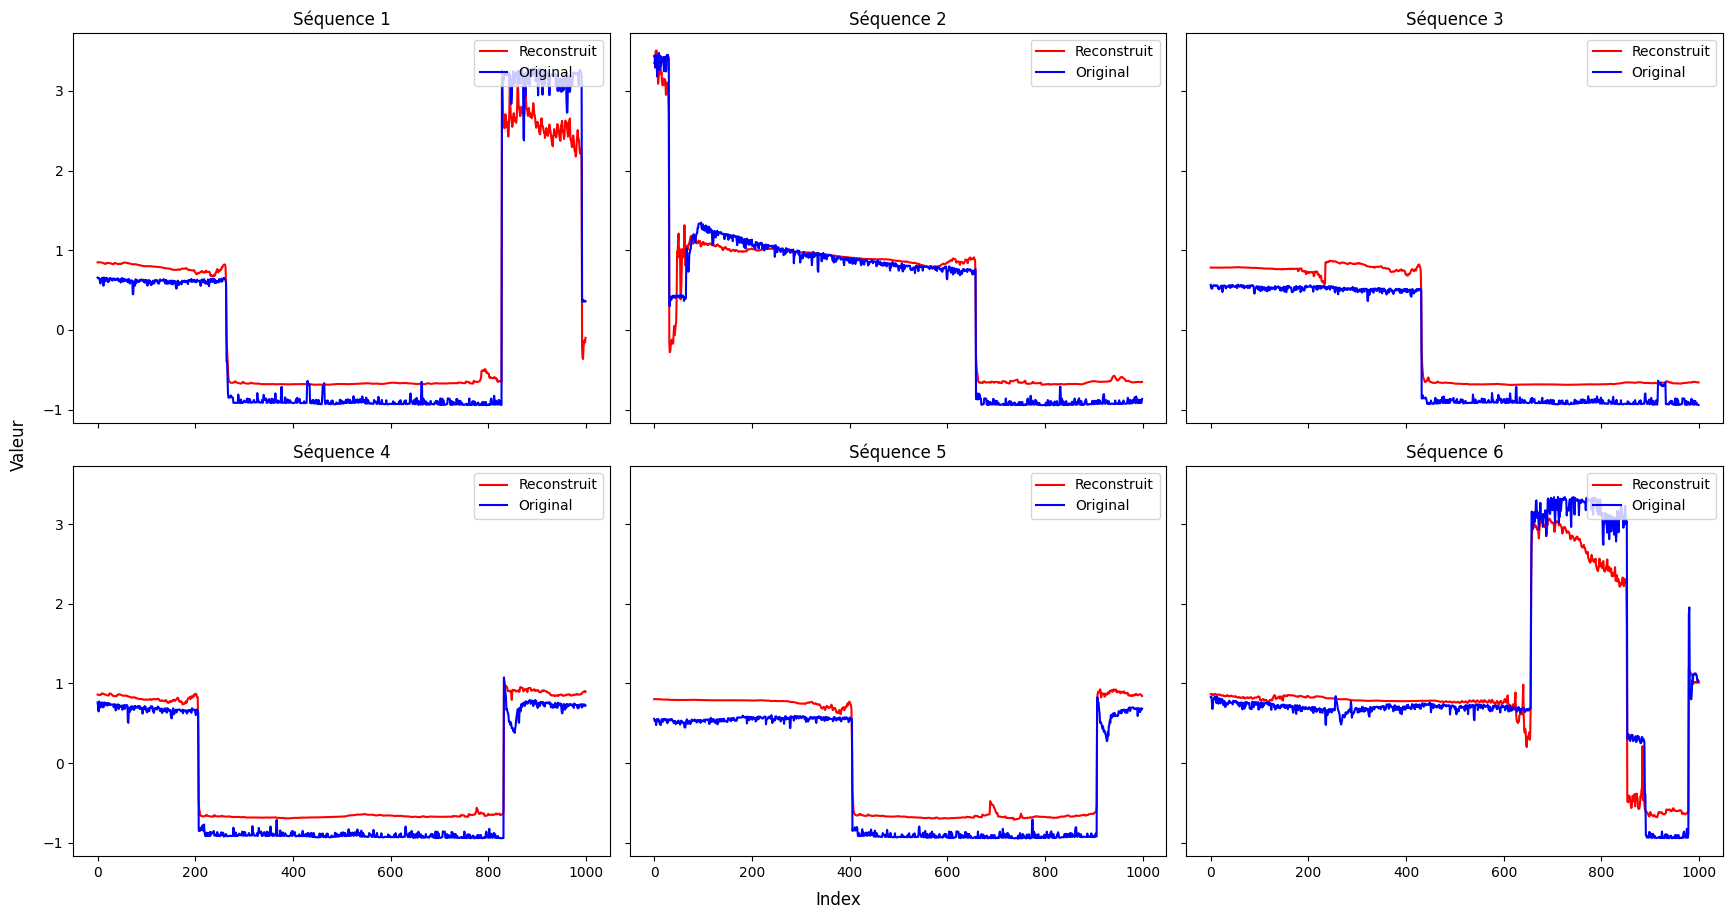

In [40]:
import matplotlib.pyplot as plt
import torch

# Définir le nombre de séquences à afficher et la taille de chaque séquence
num_sequences = 6
sequence_length = 1000

# Déterminer la longueur totale de la séquence
total_length = x_recon.numel()

# Générer des indices de départ aléatoires
random_indices = torch.randint(0, total_length - sequence_length, (num_sequences,))

# Configuration de la figure avec des sous-graphiques (2 lignes, 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Affichage de plusieurs séquences pour les données reconstruites et originales
for i in range(num_sequences):
    start_idx = random_indices[i].item()  # Indice de départ aléatoire
    end_idx = start_idx + sequence_length  # Définir le point de fin pour chaque séquence

    # Déterminer la position du subplot (ligne, colonne)
    row = i // 3
    col = i % 3

    # Tracer les séquences reconstruites
    axes[row, col].plot(
        (x_recon.view(-1))[start_idx:end_idx].cpu().numpy(),
        label='Reconstruit',
        color='red'
    )

    # Tracer les séquences originales
    axes[row, col].plot(
        (test.view(-1))[start_idx:end_idx].cpu().numpy(),
        label='Original',
        color='blue'
    )

    # Ajouter la légende à chaque sous-graphique
    axes[row, col].legend(loc='upper right')
    axes[row, col].set_title(f'Séquence {i + 1}')  # Ajouter un titre pour chaque sous-graphique

# Ajouter des labels pour les axes communs
fig.text(0.5, 0.04, 'Index', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Valeur', va='center', rotation='vertical', fontsize=12)

# Afficher la figure avec les sous-graphiques
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])  # Ajuster l'espacement des sous-graphiques
plt.show()


In [ ]:
x_recon.shape

torch.Size([46764, 1, 100])

In [41]:
# here, i have the reconstruction error of all my test dat, also a matrix of all reconstrucition on each point, what i need is to get the label of each sequence on our test data, 30% 1 => lablel = 1, donne labesl_test
tensor_squeezed = recon_loss_each_seq.squeeze(1)
print(f'tensor_squeezed {tensor_squeezed.shape}')


tensor_squeezed_cpu = tensor_squeezed.cpu()



numpy_array = tensor_squeezed_cpu.numpy()
print(numpy_array.shape)


tensor_squeezed torch.Size([5845, 800])
(5845, 800)


In [42]:
predicter_error =[]

for x in numpy_array:
    predicter_error.append(x.mean())

In [43]:
threshold = np.mean(list_loss) + 2*(np.std(list_loss))
print(threshold)

0.11998162913234764


In [44]:
predicted = np.where(np.array(predicter_error) > threshold, 1, 0)

In [45]:
threshold

0.11998162913234764

In [46]:
# labesl_test

accuracy = accuracy_score(labesl_test, predicted)
recall = recall_score(labesl_test, predicted, pos_label=1)
f1 = f1_score(labesl_test, predicted, pos_label=1)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8464
Recall: 0.1910
F1-score: 0.1968


In [47]:
labesl_test.sum()

576

In [48]:
cm = confusion_matrix(labesl_test, predicted)
print(cm)

[[4837  432]
 [ 466  110]]


In [49]:
cm = confusion_matrix(labesl_test, predicted)
print(cm)

[[4837  432]
 [ 466  110]]
